In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [11]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [12]:
def find_and_draw_matches(img1_path, img2_path):
    MIN_MATCH_COUNT = 10

    # Leer las imágenes
    img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)

    # Inicializar ORB detector
    orb = cv2.ORB_create()

    # Encontrar keypoints y descriptores con ORB
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)

    # Matcher BF con parámetros predeterminados
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    # Aplicar test de ratio
    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append(m)

    if len(good) > MIN_MATCH_COUNT:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

        # Encontrar Homografía
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        matchesMask = mask.ravel().tolist()

        h, w = img1.shape
        pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
        dst = cv2.perspectiveTransform(pts, M)

        img2 = cv2.polylines(img2, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)
    else:
        print("No se encontraron suficientes coincidencias - %d/%d" % (len(good), MIN_MATCH_COUNT))
        matchesMask = None

    # Dibujar coincidencias
    draw_params = dict(matchColor=(0, 255, 0), singlePointColor=None, matchesMask=matchesMask, flags=2)
    img3 = cv2.drawMatches(img1, kp1, img2, kp2, good, None, **draw_params)

    plt.imshow(img3, 'gray')
    plt.show()

def create_panorama(img1_path, img2_path):
    # Leer las imágenes
    img1 = cv2.imread(img1_path)
    img2 = cv2.imread(img2_path)

    # Convertir a escala de grises
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Inicializar el detector ORB
    orb = cv2.ORB_create(nfeatures=5000)

    # Encontrar keypoints y descriptores
    kp1, des1 = orb.detectAndCompute(img1_gray, None)
    kp2, des2 = orb.detectAndCompute(img2_gray, None)

    # Matcher BF con test de ratio
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)

    # Ordenar las coincidencias por distancia
    matches = sorted(matches, key=lambda x: x.distance)

    # Mantener solo las mejores coincidencias
    good_matches = matches[:100]

    # Verificar si se encontraron suficientes coincidencias
    MIN_MATCH_COUNT = 10
    if len(good_matches) > MIN_MATCH_COUNT:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        # Encontrar Homografía
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        matchesMask = mask.ravel().tolist()

        # Warping y combinación de imágenes
        h, w = img1.shape[:2]
        panorama = cv2.warpPerspective(img1, M, (w + img2.shape[1], h))
        panorama[0:img2.shape[0], 0:img2.shape[1]] = img2

        # Mostrar las mejores coincidencias
        img_matches = show_matches(img1, kp1, img2, kp2, good_matches, matchesMask)
        plt.figure(figsize=(20, 10))
        plt.imshow(img_matches)
        plt.title('Mejores Coincidencias')
        plt.axis('off')
        plt.show()

        # Mostrar la imagen panorámica resultante
        plt.figure(figsize=(20, 10))
        plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
        plt.title('Panorámica')
        plt.axis('off')
        plt.show()
    else:
        print(f"No se encontraron suficientes coincidencias: {len(good_matches)}/{MIN_MATCH_COUNT}")


No se encontraron suficientes coincidencias - 6/10


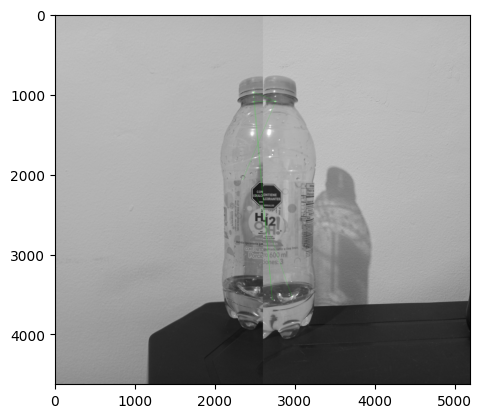

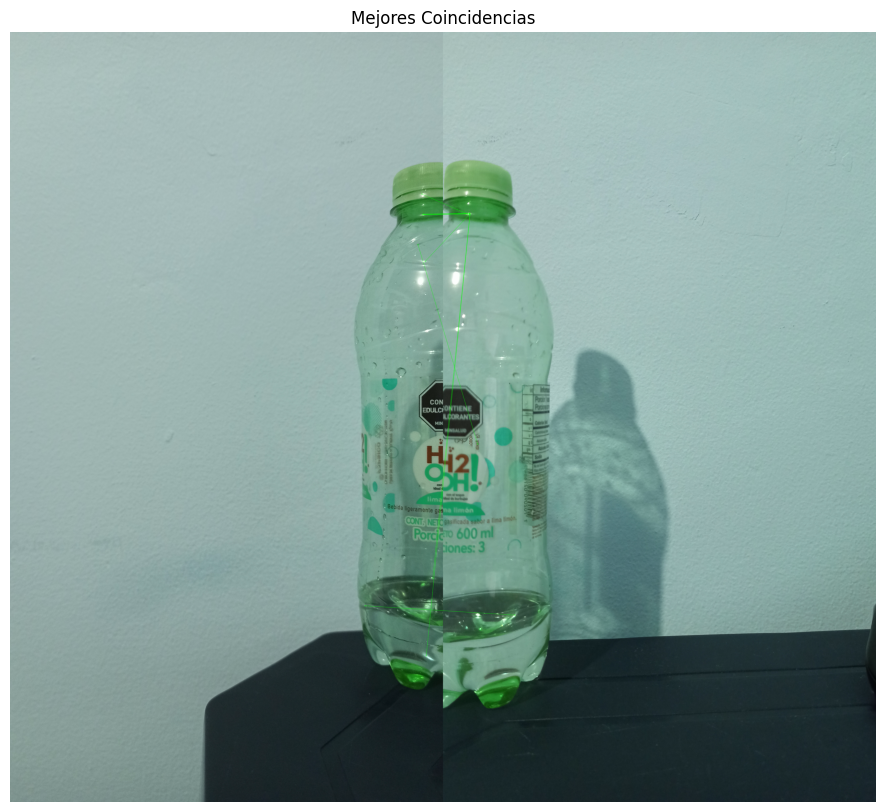

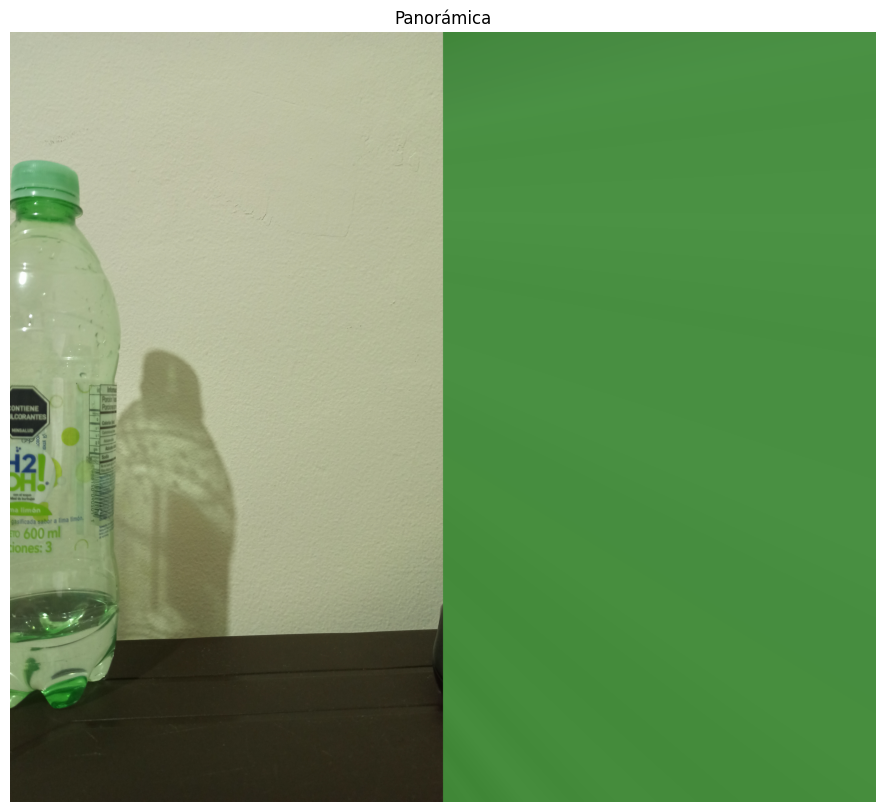

In [13]:
# Rutas de las imágenes
img1_path = '/content/drive/MyDrive/Eafit - Semestre 10/Visión por computador/Talleres/Taller 6/IMG_A.jpg'
img2_path = '/content/drive/MyDrive/Eafit - Semestre 10/Visión por computador/Talleres/Taller 6/IMG_B.jpg'

# Ejecutar las funciones
find_and_draw_matches(img1_path, img2_path)
create_panorama(img1_path, img2_path)
